In [34]:
import gurobipy as gp
from gurobipy import GRB
from gurobipy import tuplelist
import itertools  
import pandas as pd
import os
import math
import matplotlib.pyplot as plt

In [35]:

data = pd.read_csv(r"data/unique_200.csv")

In [36]:
data.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,genre
0,8194,47,77,72,150,96,161,224,Drama
1,4098,110,119,87,147,259,93,24,Drama
2,3074,185,157,21,77,124,133,47,Western
3,55814,161,116,46,142,86,32,181,Drama
4,8711,169,178,239,45,87,14,250,Comedy


In [37]:
row = data.iloc[ :,0]

In [38]:
movies = [i for i in range(1,265)]
nrow = len(data)
ncol = int(data.size/len(data))
print(ncol)

9


In [39]:
rankDic = {}
rankList = []
for i in range(1,ncol-1):
    row = data.iloc[:,i ]
    
    #print(row)
    rank = {}
    for j in range(0,nrow):
        rankDic[(i-1,row[j])] = j
        rank[row[j]] = j  
    rankList.append(rank)

In [40]:
itemList = movies

In [41]:
group = data.iloc[:, 8]
set(group)

{'Comedy',
 'Documentary',
 'Drama',
 'Film-Noir',
 'Horror',
 'Musical',
 'Thriller',
 'Western'}

In [42]:
G1 = []
G2 = []
G3 = []
G4 = []
G5 = []
G6 = []
G7= []
G8 = []
for i in range(0,len(movies)):
    if(group[i] == "Comedy"):
        G1.append(group[i])
    elif(group[i] == "Documentary"):
        G2.append(group[i])
    elif(group[i] == "Drama"):
        G3.append(group[i])
    elif(group[i] == "Film-Noir"):
        G4.append(group[i])
    elif(group[i] == "Horror"):
        G5.append(group[i])
    elif(group[i] == "Musical"):
        G6.append(group[i])
    elif(group[i] == "Thriller"):
        G7.append(group[i])
    else:
        G8.append(group[i])

In [43]:
p1 = len(G1)/len(itemList)
p2 = len(G2)/len(itemList)
p3 = len(G3)/len(itemList)
p4 = len(G4)/len(itemList)
p5 = len(G5)/len(itemList)
p6 = len(G6)/len(itemList)
p7 = len(G7)/len(itemList)
p8 = len(G8)/len(itemList)

In [44]:
P = {'Comedy':p1,'Documentary':p2,'Drama':p3,'Film-Noir':p4,
     'Horror':p5,'Musical':p6,'Thriller':p7,'Western':p8}

In [45]:
sum(P.values())

1.0

In [46]:
A = list(P.keys())
A

['Comedy',
 'Documentary',
 'Drama',
 'Film-Noir',
 'Horror',
 'Musical',
 'Thriller',
 'Western']

In [47]:
S={}
for a in A:
   
    scoreList = []
    
    S[a] = scoreList

In [48]:
A[2]

'Drama'

In [49]:
score = len(rank)
for i in rank:
    if group[i-1] == 'Comedy':
        S[A[0]].append((score,i))
    if group[i-1] == 'Documentary':
        S[A[1]].append((score,i))
    if group[i-1] == 'Drama':
        S[A[2]].append((score,i))
    if group[i-1] == 'Film-Noir':
        S[A[3]].append((score,i))
    if group[i-1] == 'Horror':
        S[A[4]].append((score,i))
    if group[i-1] == 'Musical':
        S[A[5]].append((score,i))
    if group[i-1] == 'Thriller':
        S[A[6]].append((score,i))
    if group[i-1] == 'Western':
        S[A[7]].append((score,i))
    
    score = score - 1

In [50]:
def swap(dict,i,j):
    item = dict[i]
    dict[i] = dict[j]
    dict[j] = item 

In [51]:
len(S['Comedy'])

58

In [52]:
len(rank)

268

In [53]:
P['Drama']

0.5871212121212122

In [54]:
def DetConstSort(S,A,P,kmax):
    counts = {}
    minCounts = {}
    for ai in A:
        counts[ai] = 0
        minCounts[ai] = 0
    
    rankedAttList = {}
    rankedScoreList = {}
    maxIndices = {}
    lastEmpty = 0
    k = 0
    
    while lastEmpty <= kmax:
        k = k + 1
        tempMinCounts = {}
        for ai in A:
            tempMinCounts[ai] = math.floor(k * P[ai])
        changedMins = []
        for ai in A:
            if minCounts[ai ] < tempMinCounts[ai]:
                #print(ai,counts[ai])
                changedMins.append((S[ai][counts[ai]],ai))
        if len(changedMins) != 0 :
            changedMins.sort(reverse=True)
            #ordChangedMins = changedMins
        for sai,ai in  changedMins:
            rankedAttList[lastEmpty] = ai
            #print(ai)
            rankedScoreList[lastEmpty] = S[ai][counts[ai]]
            maxIndices[lastEmpty] = k
            start = lastEmpty
            while start > 0 and maxIndices[start - 1] >= start and rankedScoreList[start-1][0] < rankedScoreList[start][0]:
                swap(maxIndices,start - 1,start)
                swap(rankedAttList,start - 1, start)
                swap(rankedScoreList,start - 1, start)
                start = start - 1
            counts[ai] = counts[ai] + 1 
            lastEmpty = lastEmpty + 1
        minCounts = tempMinCounts
    return (rankedAttList, rankedScoreList)

In [55]:
kmax = 250 #len(rank) - 1
rankedAttList,rankedScoreList = DetConstSort(S,A,P,kmax)

In [56]:
detOut = []
for key in rankedScoreList.keys():
    detOut.append(rankedScoreList[key][1])

In [57]:

def ApproxMultiValuedIPF(rank,group):
    rankGrp = {}
    for i in range(0,len(rank)):
        rankGrp[rank[i]] = group[i]

    grpCount = {}
    for i in group:
        grpCount[i] = 0

    rankGrpPos = {}
    for i in rank:
        grpCount[rankGrp[i]] = grpCount[rankGrp[i]] + 1
        rankGrpPos[i] = grpCount[rankGrp[i]]
    numberOfItem = len(rank)
    rankRange = {}
    for item in rank:
        i = rankGrpPos[item]
        n = numberOfItem
        fp = grpCount[rankGrp[item]]
        r1 = math.floor(i*n/fp)
        r2 = math.ceil((i+1)*n/fp) - 1
        if r2 > numberOfItem:
            r2 = numberOfItem
        rankRange[item] = (r1,r2)


    B = nx.Graph()
    top_nodes = []
    bottom_nodes = []

    for i in rank:
        top_nodes.append(i)
        bottom_nodes.append(str(i))
    B.add_nodes_from(top_nodes, bipartite=0)
    B.add_nodes_from(bottom_nodes, bipartite=1)

    for i in rank:
        r1,r2 = rankRange[i]
        #print(r1,r2)
        for j in range(1,numberOfItem+1):
            if j >= r1 and j <= r2:
                print(i,j)
                B.add_edge(i, str(j), weight = abs(i-j))
            else:
                B.add_edge(i, str(j), weight=1000000000)
                print(i,j)

    my_matching = nx.algorithms.bipartite.minimum_weight_full_matching(B, top_nodes, "weight")

In [58]:
newOut = []

In [59]:
A

['Comedy',
 'Documentary',
 'Drama',
 'Film-Noir',
 'Horror',
 'Musical',
 'Thriller',
 'Western']

In [60]:
def KendallTau(P,Q,allids):
    combinations = [p for p in itertools.product(allids, repeat=2)]
    distance = 0
    for tup in combinations:
        if P[tup[0]] < P[tup[1]] and  Q[tup[1]] < Q[tup[0]]:
            distance = distance + 1
    return distance
P={}
Q = {}
import itertools
allids = []
for i in range(0,len(detOut)):
    allids.append(i)
    


In [65]:

res = pd.read_csv("Fig_3c_result.csv")
res.head()
x = list(res.iloc[0, :])
y = list(res.iloc[1, :])
z = list(res.iloc[2, :])


In [66]:
# posCheck = [10,25,50,100,500,1000]
# z_det = []
# y_out = [100 for i in range(len(rank))]
# sumFail = 0
# count = {'Comedy':0,'Documentary':0,'Drama':0,'Film-Noir':0,
#         'Horror':0,'Musical':0,'Thriller':0,'Western':0}
# x_detConst = []
# y = []

# totalViolates = 0
# itrCount = 0
# sumtfail = 0

# for i in detOut:
#     itrCount = itrCount + 1
#     itemGrp = group[i-1]
#     count[str(itemGrp)] = count[str(itemGrp)] + 1
    
#     violates = False
#     tViolates = 0
#     for j in A:
#         bot = math.floor(itrCount*P[j])
#         top = math.ceil(itrCount*P[j])
#         #print(j,bot,top)
#         if (count[j] > top or count[j] <  bot):
#             violates = True
#             tViolates = tViolates + 1
            
#     if violates == True:
#         totalViolates = totalViolates + 1
#     sumtfail = sumtfail + 8 - tViolates
#     z_det.append((sumtfail/itrCount)/8*100)
#     #print(n,totalViolates)
# #     itrCount = itrCount + 1
# #     x_detConst.append((itrCount-totalViolates)/itrCount*100)
# #     print('group satisfied by DetConstSort = ',itrCount,(itrCount-totalViolates)/itrCount*100)

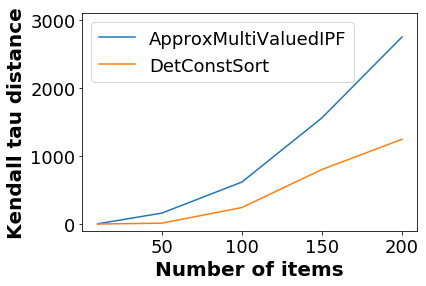

In [67]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(nrows=1, ncols=1)
plt.plot(x,y)
plt.plot(x,z)
# create an index for each tick position

plt.ylabel('Kendall tau distance',fontweight='bold',fontsize=20)
plt.xlabel('Number of items',fontweight='bold',fontsize=20)

#plt.xticks([100,20,30,40,50], ['10','20','30','40','50'])
#plt.yticks([0,10,20,30,40], ['0','10','20','30',''])
plt.legend(["ApproxMultiValuedIPF","DetConstSort"],fontsize=18)
plt.ylim([-100,3100])
#fig.savefig("newfig/fig_3/new/ApproxMultiValuedIPF_vs_detConstSort_movielens_kendall_tau.png", bbox_inches='tight', dpi=480)
plt.show()